In [1]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import access_br_dwgd as access_br_dwgd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import sys, os
sys.path.append(os.path.abspath(".."))

from utils.lstmModel import LstmModel
import utils.lstm as lstm
from utils.logger import Logger
logger = Logger.configurar_logger(nome_arquivo="lstmBrDwgd.log", nome_classe="Lstm BrDwgd")
logger.info("Iniciando script de previsão com LSTM BrDwgd.")

2025-10-01 22:22:18,829 - Lstm BrDwgd - INFO - Iniciando script de previsão com LSTM BrDwgd.


2025-10-01 22:22:20,467 - Lstm BrDwgd - INFO - Dados carregados com sucesso. Total de 5924 registros.


[-22.98833275 -43.19055557  25.59000015]


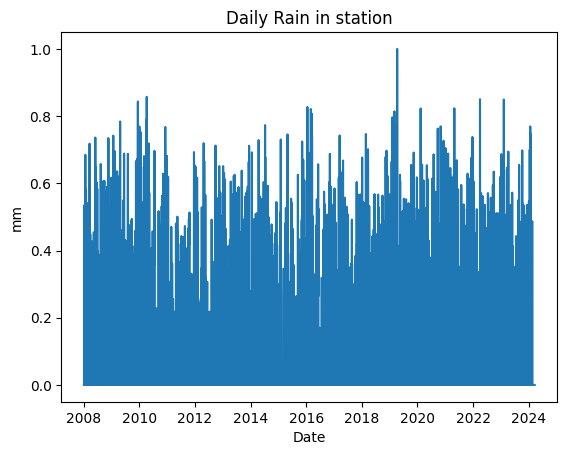

In [2]:
#Precipitation (pr, mm);
timeseries = access_br_dwgd.recuperar_dados_br_dwgd_com_area()
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(timeseries.values.reshape(-1, 1))
timeseries = pd.Series(df_scaled.flatten(), index=timeseries.index)
logger.info(f"Dados carregados com sucesso. Total de {len(timeseries)} registros.")
datas = timeseries.index 
plt.plot(timeseries)
plt.title('Daily Rain in station')
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()


In [3]:
lookback = 10
logger.info(f"Preparando sequências com um lookback de {lookback} dias.")
X, y = lstm.create_sequences_pytorch(timeseries, lookback=lookback)
train_size = int(len(timeseries) * 0.77)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


dates_aligned = datas[lookback:]
train_date, test_date = dates_aligned[:train_size] , dates_aligned[train_size:]
logger.info(f"Sequências criadas. Treino: {len(X_train)} amostras, Teste: {len(X_test)} amostras.")


2025-10-01 22:22:20,603 - Lstm BrDwgd - INFO - Preparando sequências com um lookback de 10 dias.
/home/pbose/tcc/pesquisa/utils/lstm.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = input_data[i+lookback]
2025-10-01 22:22:20,986 - Lstm BrDwgd - INFO - Sequências criadas. Treino: 4561 amostras, Teste: 1353 amostras.


In [4]:
n_epochs = 700
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=batch_size)
model = LstmModel(input_dim=1, hidden_dim=256, layer_dim=2, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [5]:
logger.info(f"Iniciando treinamento do modelo por {n_epochs} épocas com batch_size de {batch_size}.")
best_loss = float("inf")
best_state = None
# --- Loop de Treinamento ---
# Este loop agora foca APENAS em treinar o modelo
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad() # zera os gradientes
        y_pred, _ = model(Xb)             # faz forward
        loss = criterion(y_pred, yb) # calcula erro (MSE)
        loss.backward()  # backpropagation (calcula gradientes)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()  # ajusta os pesos do modelo
        epoch_loss += loss.item() * Xb.size(0)
  
    logger.debug(f"Época {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(loader):.6f}")

y_pred_np, y_test_np = None, None
# --- Bloco de Avaliação Final (executado apenas uma vez) ---
logger.info("Treinamento finalizado.")
model.eval()  # modo avaliação
with torch.no_grad():
    # Previsões no conjunto de teste
    X_test_device = X_test.to(device)
    y_pred_test, _ = model(X_test_device)   
    # Se for LSTM com saída 2D (batch, 1), transforma para 1D
    y_pred_np = y_pred_test.cpu().numpy().flatten()
    y_test_np = y_test.cpu().numpy().flatten()

    y_pred_inv = scaler.inverse_transform(y_pred_np.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test_np.reshape(-1, 1))
    y_pred_np = np.expm1(y_pred_inv)  # volta para mm de chuva
    y_test_np = np.expm1(y_test_inv)
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    
    # MSE
    mse = mean_squared_error(y_test_np, y_pred_np)
    
    # MAE
    mae = mean_absolute_error(y_test_np, y_pred_np)
    
print(f"Conjunto de Teste:")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
logger.info(f"Avaliação do Modelo - RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")


# --- Novo Bloco para Imprimir Previsto vs. Esperado ---
logger.info("\n--- Comparando Valores Previstos vs. Esperados (10 primeiros exemplos do teste) ---")
model.eval()
with torch.no_grad():
    # Itera sobre os 10 primeiros exemplos e imprime lado a lado
    for i in range(10):
        previsto = y_pred_np[i][0]
        esperado = y_test_np[i][0]
        logger.info(f"Exemplo {i+1}: Previsto = {previsto}, Esperado = {esperado}")

2025-10-01 22:22:21,834 - Lstm BrDwgd - INFO - Iniciando treinamento do modelo por 700 épocas com batch_size de 32.
2025-10-01 22:22:23,973 - Lstm BrDwgd - DEBUG - Época 1/700, Loss: 1.019068
2025-10-01 22:22:25,858 - Lstm BrDwgd - DEBUG - Época 2/700, Loss: 0.946451
2025-10-01 22:22:27,551 - Lstm BrDwgd - DEBUG - Época 3/700, Loss: 0.903576
2025-10-01 22:22:29,547 - Lstm BrDwgd - DEBUG - Época 4/700, Loss: 0.900082
2025-10-01 22:22:31,700 - Lstm BrDwgd - DEBUG - Época 5/700, Loss: 0.897915
2025-10-01 22:22:34,618 - Lstm BrDwgd - DEBUG - Época 6/700, Loss: 0.896427
2025-10-01 22:22:36,985 - Lstm BrDwgd - DEBUG - Época 7/700, Loss: 0.895321
2025-10-01 22:22:39,170 - Lstm BrDwgd - DEBUG - Época 8/700, Loss: 0.894441
2025-10-01 22:22:41,193 - Lstm BrDwgd - DEBUG - Época 9/700, Loss: 0.893714
2025-10-01 22:22:43,103 - Lstm BrDwgd - DEBUG - Época 10/700, Loss: 0.893089
2025-10-01 22:22:45,060 - Lstm BrDwgd - DEBUG - Época 11/700, Loss: 0.892539
2025-10-01 22:22:47,032 - Lstm BrDwgd - DEBUG 

Conjunto de Teste:
RMSE: 11.1064
MSE: 123.3516
MAE: 4.2003


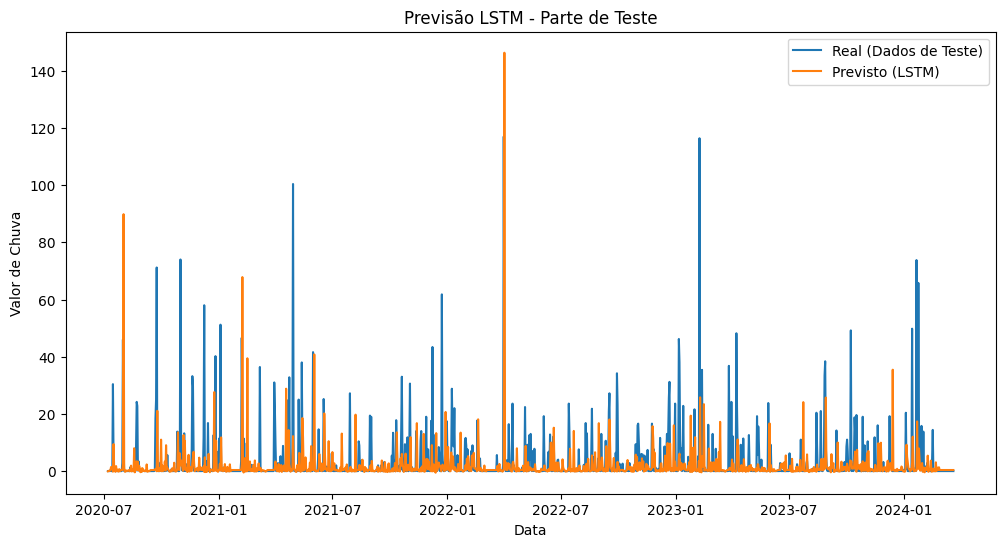

2025-10-01 22:42:54,424 - Lstm BrDwgd - INFO - Execução do script LSTM com BrDwgd finalizada.


In [6]:
plt.figure(figsize=(12, 6))
plt.plot(test_date, y_test_np, label="Real (Dados de Teste)")
plt.plot(test_date, y_pred_np, label="Previsto (LSTM)")
plt.title("Previsão LSTM - Parte de Teste")
plt.xlabel("Data")
plt.ylabel("Valor de Chuva")
plt.legend()
plt.show()
logger.info("Execução do script LSTM com BrDwgd finalizada.")